### Step By Step : Prior Fitted Networks
This notebook builds a prior fittend network for simple regression step by step. 

In [20]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

First, we will build our transformers. Here we use a 2 layer transformer where the input is first embedded into a 64 layer feature space, which is followed by two standard transfromer blocks (with the defult activations fucntion being ReLU) and an output function. The input is: 
 - B: Batch number, each of which is a different task
 - N: The number of data points for each specific task
 - Q: The query data points for each task, for prediction

Note that while in many implementations ([such as TabPFN](https://www.automl.org/automl-for-x/tabular-data/)) the attention is masked (query data point do not attend to each other) here we allow global self attention. Also, note that lack of a "pos_embedding" vector that we add to the inpute train_x before the transformer blocks!

In [6]:
# Define a 2 layer transformer Model with binary output
class PFN(nn.Module):
    def __init__(self, input_dim, emb_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.input_embed = nn.Linear(input_dim + 1, emb_dim)  # input + label
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, batch_first=True) #enable nested transformers
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_head = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, train_x, train_y, test_x):
        """
        train_x: [Batch (Each a Task), N (Training points for task), D (number of features)]
        train_y: [B, N, 1]
        test_x:  [B, Q (Queries or testing points), D]
        """
        B, N, D = train_x.size()
        Q = test_x.size(1)

        # single sequence of length N+Q that includes both support and query inputs.
        all_x = torch.cat([train_x, test_x], dim=1)  # [B, N+Q, D]
        all_y = torch.cat([train_y, torch.zeros(B, Q, 1)], dim=1)  # dummy y for test

        inp = torch.cat([all_x, all_y], dim=2)  # [B, N+Q, D+1]
        inp = self.input_embed(inp)

        # Transformer expects [seq_len, batch, emb_dim]
        #inp = inp.transpose(0, 1)  # [N+Q, B, emb_dim] no need becuase batch_first=True
        out = self.encoder(inp)  # [N+Q, B, emb_dim]
        #out = out.transpose(0, 1)  # [B, N+Q, emb_dim]

        pred = self.output_head(out[:, N:, :])  # only return test preds [B, Q, 1]
        return pred

Generare 16 tasks, each with N train and Q test points

In [9]:
def generate_task(batch_size=16, N=5, Q=10):
    """
    Generate batch of toy regression tasks: y = a*x + b + noise
    """
    a = torch.randn(batch_size, 1, 1)
    b = torch.randn(batch_size, 1, 1)

    def sample_x(n): return torch.rand(batch_size, n, 1) * 2 - 1

    train_x = sample_x(N)
    test_x = sample_x(Q)
    noise = 0.1 * torch.randn_like(train_x)
    train_y = a * train_x + b + noise
    test_y = a * test_x + b

    return train_x, train_y, test_x, test_y

In [10]:
model = PFN(input_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [30]:
for step in range(1000):
    model.train()
    train_x, train_y, test_x, test_y = generate_task()
    pred = model(train_x, train_y, test_x)
    loss = loss_fn(pred, test_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")

Step 0, Loss: 0.1147
Step 100, Loss: 0.1856
Step 200, Loss: 0.0651
Step 300, Loss: 0.1387
Step 400, Loss: 0.0373
Step 500, Loss: 0.2112
Step 600, Loss: 0.0675
Step 700, Loss: 0.0489
Step 800, Loss: 0.2200
Step 900, Loss: 0.0403


Generare a new task, Note that N and Q test have different values, this is fine becuase the multi-head attention matricies computed $W^k,W^q$ and $W^v$ are all of size 64/4=16 and we can use them to calculate attention maps for any arbitrary sequence length. Note however that a small support set (small N) will result in low accucarcy! feel free to modify N and explore how performance is imapacted!

In [27]:
trn_x, trn_y, tst_x, tst_y = generate_task(batch_size=1, N=5, Q=50)

In [32]:
model.eval()
with torch.no_grad():
    pred = model(trn_x, trn_y, tst_x) 

After only 1K iterations

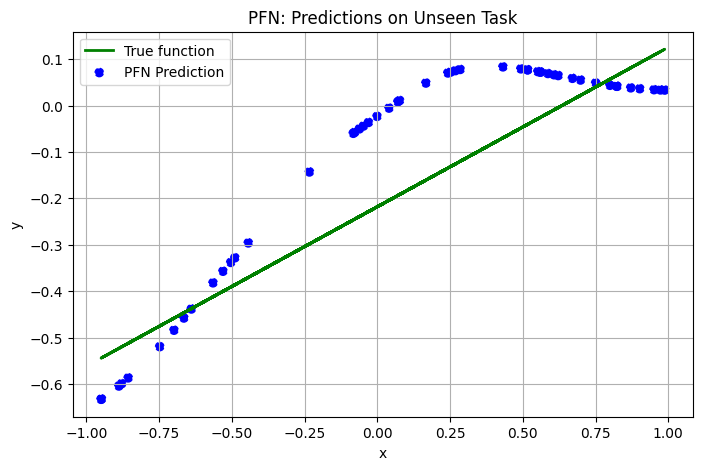

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(tst_x.squeeze().cpu().numpy(), tst_y.squeeze().cpu().numpy(), label='True function', color='green', linewidth=2)
plt.scatter(tst_x.squeeze().cpu().numpy(), pred.squeeze().cpu().numpy(), label='PFN Prediction', color='blue', linestyle='--')
plt.legend()
plt.title("PFN: Predictions on Unseen Task")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

Now we run the training loop again and look at the resuls after 2K iterations

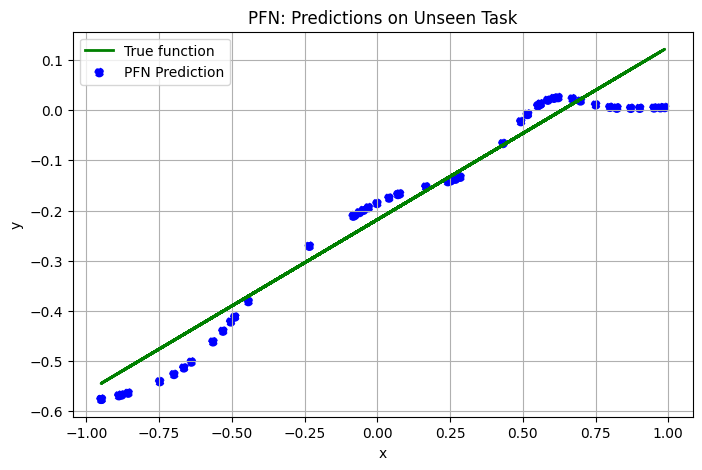

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(tst_x.squeeze().cpu().numpy(), tst_y.squeeze().cpu().numpy(), label='True function', color='green', linewidth=2)
plt.scatter(tst_x.squeeze().cpu().numpy(), pred.squeeze().cpu().numpy(), label='PFN Prediction', color='blue', linestyle='--')
plt.legend()
plt.title("PFN: Predictions on Unseen Task")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()